# Experiment 5
Apply transfer learning to MobileNetV2 (trained on ImageNet) with data augmentation

In [1]:
# model training using tensorflow
import numpy as np
import os
import cv2
from matplotlib import pyplot

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
'''
Configuration Code
'''
def get_n_cores():
    """The NSLOTS variable, If NSLOTS is not defined throw an exception."""
    nslots = os.getenv("NSLOTS")
    if nslots is not None:
        return int(nslots)
    raise ValueError("Environment variable NSLOTS is not defined.")


os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

NUM_GPUS = len(tf.config.experimental.list_physical_devices("GPU"))
print("Num GPUs Available: ", NUM_GPUS)
if NUM_GPUS > 0:
    print(os.getenv("CUDA_VISIBLE_DEVICES"))

tf.config.set_soft_device_placement(True)
tf.keras.backend.set_floatx("float32")
tf.config.threading.set_intra_op_parallelism_threads(1)
tf.config.threading.set_inter_op_parallelism_threads(get_n_cores())

Num GPUs Available:  1
0


In [4]:
batch_size = 32

DATA_DIRECTORY = os.path.join(os.getcwd(), 'train_data')

size = (224,224) # height, width

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  DATA_DIRECTORY,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=size,
  batch_size=batch_size
)

Found 2700 files belonging to 2 classes.
Using 2160 files for training.


In [5]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  DATA_DIRECTORY,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=size,
  batch_size=batch_size
)

Found 2700 files belonging to 2 classes.
Using 540 files for validation.


In [6]:
'''
Set the base model to MobileNetV2 (trained on ImageNet)
'''
IMG_SHAPE = size + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [7]:
# do not allow the NN to train the base network
base_model.trainable = False

In [8]:
# create the additional layers for the end
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(2)

In [9]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255, input_shape=(224,224,3))

In [10]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(224,224,3)),
    layers.experimental.preprocessing.RandomFlip("vertical", input_shape=(224,224,3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [11]:
# chain the layers together to make the complete model
inputs = tf.keras.Input(shape=(224, 224, 3))
x = normalization_layer(inputs)
x = data_augmentation(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [12]:
# we need a low learning rate to avoid overfitting
base_learning_rate = 0.0001

model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [13]:
epochs=100

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[callback]
)

Epoch 1/100
68/68 [==============================] - 7s 99ms/step - loss: 0.6787 - accuracy: 0.6370 - val_loss: 0.5626 - val_accuracy: 0.7074
Epoch 2/100
68/68 [==============================] - 5s 80ms/step - loss: 0.5574 - accuracy: 0.7097 - val_loss: 0.4601 - val_accuracy: 0.7981
Epoch 3/100
68/68 [==============================] - 5s 77ms/step - loss: 0.4784 - accuracy: 0.7685 - val_loss: 0.4008 - val_accuracy: 0.8426
Epoch 4/100
68/68 [==============================] - 5s 79ms/step - loss: 0.4481 - accuracy: 0.7921 - val_loss: 0.3698 - val_accuracy: 0.8556
Epoch 5/100
68/68 [==============================] - 6s 82ms/step - loss: 0.4127 - accuracy: 0.8162 - val_loss: 0.3431 - val_accuracy: 0.8685
Epoch 6/100
68/68 [==============================] - 5s 75ms/step - loss: 0.3720 - accuracy: 0.8343 - val_loss: 0.3237 - val_accuracy: 0.8815
Epoch 7/100
68/68 [==============================] - 5s 78ms/step - loss: 0.3781 - accuracy: 0.8384 - val_loss: 0.3089 - val_accuracy: 0.8889
Epoch 

68/68 [==============================] - 5s 77ms/step - loss: 0.1679 - accuracy: 0.9366 - val_loss: 0.1723 - val_accuracy: 0.9389
Epoch 59/100
68/68 [==============================] - 5s 77ms/step - loss: 0.1726 - accuracy: 0.9361 - val_loss: 0.1719 - val_accuracy: 0.9389
Epoch 60/100
68/68 [==============================] - 6s 84ms/step - loss: 0.1809 - accuracy: 0.9343 - val_loss: 0.1725 - val_accuracy: 0.9407
Epoch 61/100
68/68 [==============================] - 6s 82ms/step - loss: 0.1614 - accuracy: 0.9366 - val_loss: 0.1727 - val_accuracy: 0.9389
Epoch 62/100
68/68 [==============================] - 6s 82ms/step - loss: 0.1702 - accuracy: 0.9417 - val_loss: 0.1727 - val_accuracy: 0.9370
Epoch 63/100
68/68 [==============================] - 6s 84ms/step - loss: 0.1733 - accuracy: 0.9315 - val_loss: 0.1747 - val_accuracy: 0.9352
Epoch 64/100
68/68 [==============================] - 5s 79ms/step - loss: 0.1669 - accuracy: 0.9315 - val_loss: 0.1731 - val_accuracy: 0.9389


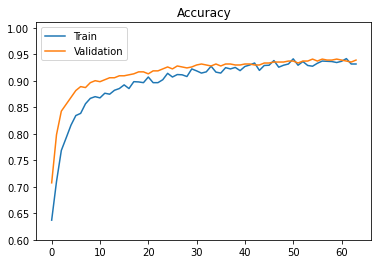

In [14]:
'''
Plot the accuracy
'''
pyplot.title("Accuracy")
pyplot.plot(range(len(history.history['accuracy'])), history.history['accuracy'], label = "Train")
pyplot.plot(range(len(history.history['val_accuracy'])), history.history['val_accuracy'], label = "Validation")
pyplot.ylim((0.6, 1.01))
pyplot.legend()
pyplot.show()

In [15]:
# save the model
model.save("models/{}".format("experiment_005a"))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/experiment_005a/assets


In [16]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                

Fine-tuning can hopefully improve the model still. The last 50 layers of MobileNetV2 will be unlocked to allow for gradient adjustments

In [17]:
# change to fine tuning
base_model.trainable = True

# this is the layer to start fine tuning at
fine_tune_at = len(base_model.layers) - 50

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [18]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/100),
              metrics=['accuracy'])

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                

In [19]:
fine_tune_epochs = 100
total_epochs =  history.epoch[-1] + fine_tune_epochs

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)

history_fine = model.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=val_ds,
    callbacks = [callback]
)


Epoch 64/163
68/68 [==============================] - 7s 110ms/step - loss: 0.1646 - accuracy: 0.9403 - val_loss: 0.1654 - val_accuracy: 0.9407
Epoch 65/163
68/68 [==============================] - 6s 94ms/step - loss: 0.1531 - accuracy: 0.9472 - val_loss: 0.1601 - val_accuracy: 0.9389
Epoch 66/163
68/68 [==============================] - 6s 94ms/step - loss: 0.1521 - accuracy: 0.9431 - val_loss: 0.1536 - val_accuracy: 0.9389
Epoch 67/163
68/68 [==============================] - 6s 89ms/step - loss: 0.1371 - accuracy: 0.9495 - val_loss: 0.1505 - val_accuracy: 0.9407
Epoch 68/163
68/68 [==============================] - 6s 82ms/step - loss: 0.1290 - accuracy: 0.9537 - val_loss: 0.1470 - val_accuracy: 0.9444
Epoch 69/163
68/68 [==============================] - 6s 88ms/step - loss: 0.1407 - accuracy: 0.9454 - val_loss: 0.1381 - val_accuracy: 0.9481
Epoch 70/163
68/68 [==============================] - 6s 86ms/step - loss: 0.1291 - accuracy: 0.9509 - val_loss: 0.1388 - val_accuracy: 0.946

68/68 [==============================] - 6s 81ms/step - loss: 0.0420 - accuracy: 0.9866 - val_loss: 0.0699 - val_accuracy: 0.9741
Epoch 122/163
68/68 [==============================] - 6s 82ms/step - loss: 0.0423 - accuracy: 0.9880 - val_loss: 0.0709 - val_accuracy: 0.9741
Epoch 123/163
68/68 [==============================] - 6s 88ms/step - loss: 0.0496 - accuracy: 0.9833 - val_loss: 0.0700 - val_accuracy: 0.9722
Epoch 124/163
68/68 [==============================] - 7s 100ms/step - loss: 0.0549 - accuracy: 0.9829 - val_loss: 0.0712 - val_accuracy: 0.9722
Epoch 125/163
68/68 [==============================] - 6s 92ms/step - loss: 0.0464 - accuracy: 0.9829 - val_loss: 0.0761 - val_accuracy: 0.9667
Epoch 126/163
68/68 [==============================] - 6s 95ms/step - loss: 0.0469 - accuracy: 0.9856 - val_loss: 0.0746 - val_accuracy: 0.9648
Epoch 127/163
68/68 [==============================] - 6s 84ms/step - loss: 0.0482 - accuracy: 0.9838 - val_loss: 0.0700 - val_accuracy: 0.9722
Epoch

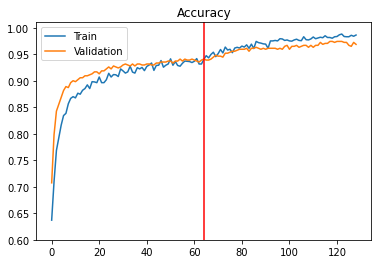

In [20]:
'''
Plot the total accuracy
'''
n = len(history.history['accuracy']) + len(history_fine.history['accuracy'])

pyplot.title("Accuracy")
pyplot.plot(range(n), history.history['accuracy'] + history_fine.history['accuracy'], label = "Train")
pyplot.plot(range(n), history.history['val_accuracy'] + history_fine.history['val_accuracy'], label = "Validation")

pyplot.axvline(x=len(history.history['loss']), color='red')
pyplot.ylim((0.6,1.01))
pyplot.legend()
pyplot.show()


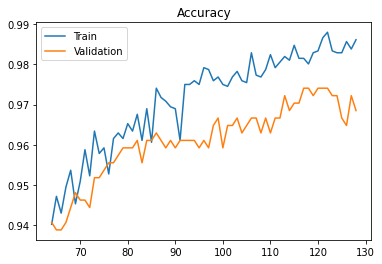

In [21]:
'''
Plot the fine tuning accuracy
'''
a = len(history.history['accuracy'])
b = len(history_fine.history['accuracy'])
c = a+b

pyplot.title("Accuracy")
pyplot.plot(range(a,c), history_fine.history['accuracy'], label = "Train")
pyplot.plot(range(a,c), history_fine.history['val_accuracy'], label = "Validation")
pyplot.legend()
pyplot.show()


In [22]:
model.save('models/experiment_005b')

INFO:tensorflow:Assets written to: models/experiment_005b/assets
